# Exploring Gender Bias in Film Dialogue with Machine Learning

![alt text](poster.jpg "Title")

## Contents
### 1. <a href='#data_collection'>Data Collection</a>
### 2. <a href='#dialogue_extraction'>Dialogue Extraction</a>
### 3. <a href='#dialogue_cleaning'>Dialogue Cleaning with ML</a>
### 4. <a href='#visualization'>Topic Modeling, Analysis, and Visualization</a>
### 5. <a href='#modeling'>ML Classification Model</a>
### 6. <a href='#modeling2'>Deep Learning Models</a>


<a></a>

In [1]:
%matplotlib inline

In [2]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
warnings.filterwarnings("ignore")

In [4]:
import os
import shutil
import collections
import itertools
from __future__ import print_function
import re
import codecs
from random import shuffle
import operator
from future_builtins import map
from collections import Counter
from itertools import chain

from bs4 import BeautifulSoup
import requests
import urllib2

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import classification_report, confusion_matrix, pairwise, roc_curve, auc
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA 

#import nltk
import gensim
from gensim.models import Word2Vec


import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU
from keras.preprocessing import sequence
from keras.layers import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer

In [6]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

<a id='data_collection'></a>

### Data Collection

In [70]:
script_df = pd.read_csv("Scripts.csv")
script_df.head()

,SCRIPT_ID,IMDB_ID,TITLE,YEAR,GROSS (inflation-adjusted)
0,1534,tt1022603,(500) Days of Summer,2009,37.0
1,1512,tt0147800,10 Things I Hate About You,1999,65.0
2,1514,tt0417385,12 and Holding,2005,NaN
3,1520,tt1542344,127 Hours,2010,20.0
4,3778,tt0103594,1492: Conquest of Paradise,1992,15.0


In [18]:
# clean script links and only select non-pdf scripts
df = pd.read_csv('script_sources.csv')
ids = df["script_id"].tolist()
links = df["link"].tolist()

link_ids = {}
for i in range(len(links)):
    link_ids[links[i]] = ids[i]

bad_links = []
for i in link_ids:
    if "imsdb" not in i or ".pdf" in i:
        bad_links.append(i)
for link in bad_links:
    link_ids.pop(link, None)

link_ids_fix = {}
for i in link_ids:
    if "film_20100519" in i:
        fix = re.sub(r'film_20100519/all_imsdb_05_19_10/','http://www.imsdb.com/scripts/', i)
        link_ids_fix[fix] = link_ids[i]
    elif "http:" in i:
        fix = re.sub(r'http://www.imsdb.com/Movie Scripts/','http://www.imsdb.com/scripts/', i)
        fix = re.sub(r'\WScript','', fix)
        fix = re.sub(r'\s','-',fix)
        link_ids_fix[fix] = link_ids[i]

In [ ]:
# download scripts
dest = "Film_Scripts/"

for i in link_ids_fix:
    try:
        r = urllib2.urlopen(i).read()
        soup = BeautifulSoup(r, 'html.parser')
        script = soup.find("td", class_="scrtext")

        if script != None:
            script_clean = re.sub(r'<b>(.*)','',script.contents[1].text)
            script_clean = re.sub(r'</b>(.*)','',script_clean)
            script_clean = re.sub(r'top.location.href=location.href','',script_clean)

            text_out = codecs.open(dest + str(link_ids_fix[i]) +".txt", "w", encoding="utf-8")
            print(script_clean, file=text_out)
            text_out.close()
    except:
        continue

In [ ]:
# Get character names for films from IMDB

imdb_ids = script_df["IMDB_ID"].tolist()
character_script_list = []

for id in imdb_ids[:1]:
    searchpage = requests.get("http://www.imdb.com/title/" + str(id) + "/fullcredits").text
    searchsoup = BeautifulSoup(searchpage)

    even_res = searchsoup.findAll(class_ = "even")
    odd_res = searchsoup.findAll(class_ = "odd")
    
    for item in even_res:
        try: 
            html_character = re.sub(r'^\n*\s*','',item.find(class_="character").text)
            character_script_list.append([id,re.sub(r'\n*\s*$','',html_character).lower()])
        except:    
            continue
            
    for item in odd_res:
        try: 
            html_character = re.sub(r'^\n*\s*','',item.find(class_="character").text)
            character_script_list.append([id,re.sub(r'\n*\s*$','',html_character).lower()])
        except:    
            continue

In [ ]:
matched_ids,characters = zip(*character_script_list)
character_df = pd.DataFrame(
    {'IMDB_ID': matched_ids,
     'Character': characters
    })
character_df.to_csv("characters1.csv")

<a id='dialogue_extraction'></a>

### Dialogue Extraction

In [6]:
character_df = pd.read_csv("character_list.csv")
character_ids = [row for row in range(len(character_df))]
character_df["character_id"] =  character_ids

In [7]:
# Note: All_Scripts folder includes some scripts from other sources that weren't collected from the above scrape

src = "All_Scripts/"
dest = "Final_Character_Dialogue/"

for filename in os.listdir(src):
    if filename != '.DS_Store':

        avoid_words = ["CUT TO", "INT", "EXT", "CONTINUED", "EXIT", "DISSOLVE", "DELETE", "FADE"]

        script = open(src + filename, "r").readlines()
        script_id = re.sub(r'\.[a-z]+$','',filename)
        temp_df = character_df[character_df["script_id"] == int(script_id)]

        characters = temp_df["imdb_character_name"].tolist()
        characters = [[character.upper()] for character in characters]
        character_id = temp_df["character_id"].tolist()

        character_id_dict = {}
        for i in range(len(characters)):
            character_id_dict[characters[i][0]] = character_id[i]

        new_characters = []
        for character in characters:
            if " " in character[0]:
                x = character[0].split()
                new_characters.append(character + x)
            else:
                new_characters.append(character)

        character_check = []
        for character in new_characters:
            for name in character:
                character_check.append(name)
        duplicates = [item for item, count in collections.Counter(character_check).items() if count > 1] 

        for character in new_characters:
            count = 0
            for name in character:
                count = count + 1
                if name in duplicates and count > 1:
                     character.remove(name)        

        character_index = {}
        for character in new_characters:
            for name in character:
                for index in range(len(script)):
                    add_lines = 1
                    if re.match(r'[\s\t]*' + re.escape(name) + r'[\r\n\t]', script[index]) or re.match(r'[\s\t]*' + re.escape(name) + r'(\(.*\))?\s*[\(\[].*[\)\]][\r\n\t]', script[index]):   
                        try:
                            if "(" in script[index + 1]:
                                while ")" not in script[index + add_lines] and add_lines < 5:
                                    add_lines += 1

                            if add_lines < 5:
                                if character[0] in character_index:
                                    character_index[character[0]].append(index + add_lines)
                                else:
                                    character_index[character[0]] = [index + add_lines]
                        except:
                            continue

        end = []
        for index in range(len(script)):
            if re.match(r'^[\r\n]',script[index]) or re.match(r"^\s*[\r\n]",script[index]):  
                end.append(index)

        if len(end) > 500:
            
            good_line = True    # is an individual line clean?

            for character in character_index:
                dialogue= ""
                for index in character_index[character]:
                    if script[index] == "\n":
                        index += 1
                    good_dialogue = True # if a capatialized character name is found, assume that all lines after are bad (false)
                    open_paren = False  # is there an open paranthesis? 
                    open_brack = False  # is there an open bracket?
                    line_count = False  # can the number of spaces for the first line of dialogue be counted?
                    if index not in end:
                        line = index
                        tab_line = False

                        first_line_count = 0
                        if "(" not in script[line]:
                            line_count = True
                            if "\t" in script[line]:
                                tab_line = True
                                while script[line][first_line_count] == "\t":
                                    first_line_count += 1
                            else:
                                while script[line][first_line_count] == " ":
                                    first_line_count += 1
                        elif "(" in script[line] and ")" in script[line]:
                            line_count = True
                            if "\t" in script[line]:
                                tab_line = True
                                while script[line + 1][first_line_count] == "\t":
                                    first_line_count += 1
                            else:
                                while script[line + 1][first_line_count] == " ":
                                    first_line_count += 1

                        while line not in end and line <= len(script) - 1:
                            line_paren = False       # are there open and closed parantheses on the same line?
                            line_brack = False       # are there open and closed brackets on the same line?

                            for character_instance in new_characters:
                                for name in character_instance:
                                    if re.match(r'[\s\t]*' + re.escape(name) + r'[\r\n\t]', script[line]) or re.match(r'[\s\t]*' + re.escape(name) + r'(\(.*\))?\s*[\(\[].*[\)\]][\r\n\t]', script[line]): 
                                        good_dialogue = False
                            for word in avoid_words:
                                if word in script[line]:
                                    good_line = False       
                            if re.search(r'^[^a-zA-Z][\n\t\s]*?[0-9]+\.?[\n\t\s]*?$',script[line]):
                                good_line = False
                            if script[line] == "\n":
                                good_line = False

                            # Test for all-capitalized lines with less than 4 words    
                            if len([letter for letter in script[line] if letter.islower() == True]) == 0:
                                if len([word for word in script[line].split(" ") if word != ""]) < 3:
                                    if "," not in script[line] and "!" not in script[line] and "?" not in script[line]:
                                        good_dialogue = False

                            if line_count == True:
                                this_line_count = 0
                                if tab_line == True:
                                    while script[line][this_line_count] == "\t":
                                        this_line_count += 1 
                                    if first_line_count > this_line_count:
                                        good_line = False
                                else:
                                    while script[line][this_line_count] == " ":
                                        this_line_count += 1 
                                    if first_line_count - this_line_count > 3:
                                        good_line = False

                            if "(" in script[line] and ")" in script[line]:
                                line_paren = True
                            if "[" in script[line] and "]" in script[line]:
                                line_brack = True
                            if script[line].count("(") > script[line].count(")"):
                                open_paren = True
                            if script[line].count("[") > script[line].count("]"):
                                open_brack = True

                            if open_paren == False:
                                if ")" in script[line] and "(" not in script[line]:
                                    good_line = False

                            if good_line == True and good_dialogue == True and open_paren == False and open_brack == False:
                                if line_paren == True:
                                    line_text = re.sub(r'\(.+?\)','',script[line])
                                    if line_text != "\n" and re.search(r'^\s+\n',line_text) == None:
                                        dialogue = dialogue + re.sub(r'^[\s]+|^[\t]+', '',line_text)
                                elif line_brack == True:
                                    line_text = re.sub(r'\[.+?\]','',script[line])
                                    if line_text != "\n" and re.search(r'^\s+\n',line_text) == None:
                                        dialogue = dialogue + re.sub(r'^[\s]+|^[\t]+', '',line_text)
                                else:
                                    dialogue = dialogue + re.sub(r'^[\s]+|^[\t]+', '',script[line])

                            if open_paren == True:
                                if script[line].count(")") > script[line].count("("):
                                    open_paren = False

                            if open_brack == True:
                                 if script[line].count("]") > script[line].count("["):
                                    open_brack = False

                            line = line + 1
                            good_line = True   

                        try:
                            text_out = codecs.open(dest + str(character_id_dict[character]) + ".txt", "w")
                            print(dialogue, file=text_out)   
                            text_out.close()
                        except:
                            continue

<a id='dialogue_cleaning'></a>

### Dialogue Cleaning with ML

Train ML model to remove direction lines that were accidentally extracted with the dialogue

In [3]:
# select scripts with consistent and standardized formatting so that directions can be extracted
src = "All_Scripts/"
good_scripts = {}

for filename in os.listdir(src):
    if filename != ".DS_Store":
        f = open(src + filename, "r")
        text = f.readlines()
        
        current_script_lines = []
        bad_script = False

        for line in text:
            if re.match("\s\s\s\s\s\s\s\s\s\s\s\s\s\s\s[A-Za-z][^A-Z].+\n",line):
                if "!" in line or "?" in line or "I'll " in line or "I'm " in line:
                    bad_script = True
                else:
                    clean_line = re.sub("\s\s\s\s\s\s\s\s\s\s\s\s\s\s\s",'',line)
                    if clean_line.count(" ") > 3:
                        current_script_lines.append(clean_line)
        if len(current_script_lines) < 10 or bad_script == True:
            continue
        else:
            good_scripts[filename] = current_script_lines
        f.close()

# combine direction lines into list
direction_lines = []
for key, value in good_scripts.iteritems():
    for line in value:
        direction_lines.append(line)

In [4]:
# get total number of direction lines extracted
len(direction_lines)

18838

In [23]:
# select an equal number of dialogue lines
src = "Final_Character_Dialogue/"
total_lines = 0
dialogue_lines = []

for filename in os.listdir(src):
    if filename != ".DS_Store":
        f = open(src + filename, "r")
        text = f.readlines()
    for line in text:
        dialogue_lines.append(line)
        total_lines += 1
        if total_lines == 18838:
            break
    if total_lines == 18838:
            break      

In [32]:
# label dialogue and directions
labeled_directions = []
labeled_dialogue = []

for line in direction_lines:
    labeled_directions.append([line,1])
    
for line in dialogue_lines:
    labeled_dialogue.append([line,0])

# combine lists and shuffle
combined_lines = labeled_directions + labeled_dialogue
shuffle(combined_lines)

In [34]:
# check to make sure everything looks right
combined_lines[:10]

[['his hand. Charlie stares straight at Haven. Haven glances at \n', 1],
 ['them for Monday.\n', 0],
 ['pattern with the shadows. There is no sound until, abruptly,\r\n', 1],
 ['Sid gets off the bed and with a grin, gingerly pats out the \n', 1],
 ['back on the floor. Meg looks up.\r\n', 1],
 ['are locked sympathetically on Tim. Smith finishes reading \n', 1],
 ["gonna need a lot of massages.  I'll take\n", 0],
 ['you.\r\n', 0],
 ["Yes'm... Figgered it might be the \n", 0],
 ['The rain pours down on Forrest and Bubba as they sit in a \n', 1]]

In [35]:
# separate data and labels into separate lists
x = [i[0] for i in combined_lines]
y = [i[1] for i in combined_lines]

# apply tfidf to data
tfidf = TfidfVectorizer(analyzer="word")
X = tfidf.fit_transform(x)

# separate into train and test (80/20)
(X_train, X_test, y_train, y_test) = train_test_split(X, y,test_size=.2)

In [152]:
svc = LinearSVC()
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.93139596602972397

In [153]:
print(classification_report(y_test,svc.predict(X_test)))

             precision    recall  f1-score   support

          0       0.93      0.93      0.93      3797
          1       0.93      0.93      0.93      3739

avg / total       0.93      0.93      0.93      7536



In [36]:
bnb = GridSearchCV(BernoulliNB(), param_grid={'alpha':np.logspace(-2., 2., 50)})
bnb.fit(X_train, y_train)
bnb.score(X_test, y_test)

0.95448513800424628

In [10]:
bnb.best_params_

{'alpha': 0.13894954943731375}

In [37]:
print(classification_report(y_test,bnb.predict(X_test)))

             precision    recall  f1-score   support

          0       0.97      0.94      0.95      3756
          1       0.94      0.97      0.96      3780

avg / total       0.95      0.95      0.95      7536



In [42]:
# instead of words, vectorize over character ngrams in the range from 2 to 7 chars

tfidf = TfidfVectorizer(analyzer="char", ngram_range=(2,7))

X = tfidf.fit_transform(x)
(X_train, X_test,y_train, y_test) = train_test_split(X, y,test_size=.2)

In [44]:
bnb2 = GridSearchCV(BernoulliNB(), param_grid={'alpha':np.logspace(-2., 2., 50)})
bnb2.fit(X_train, y_train)
bnb2.score(X_test, y_test)

0.95793524416135878

In [45]:
predictions = bnb2.predict(X_test)

In [46]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.97      0.94      0.96      3793
          1       0.94      0.98      0.96      3743

avg / total       0.96      0.96      0.96      7536



In [41]:
# get the words corresponding to each feature 
names = np.asarray(tfidf.get_feature_names())

# display the 50 words with the largest coefficients
print(','.join(names[np.argsort(bnb2.best_estimator_.coef_[0,:])[::-1][:20]]))

the,and,of,to,he,in,his,is,on,at,her,she,as,it,with,up,out,him,from,into


In [176]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

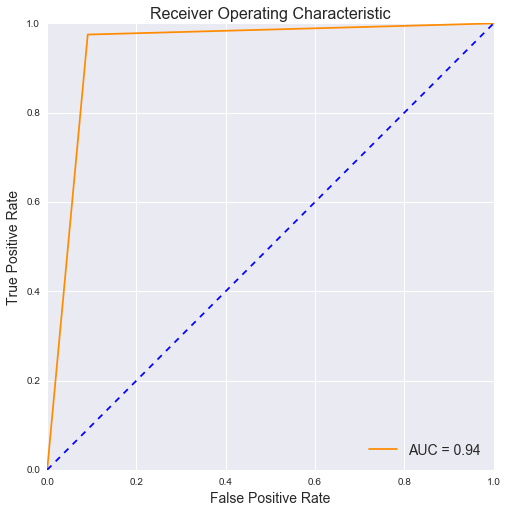

In [190]:
plt.title('Receiver Operating Characteristic', fontsize = 16)
plt.plot(fpr, tpr, color='darkorange',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right', fontsize = 14)
plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1.0])
plt.ylim([0,1.0])
plt.ylabel('True Positive Rate', fontsize = 14)
plt.xlabel('False Positive Rate', fontsize = 14)
plt.show()

In [99]:
# test model on some dialogue
src = "Final_Character_Dialogue/"
filename = "2500.txt"
f = open(src + filename, "r")
text = f.readlines()

text_tf = tfidf.transform(text)
scores = bnb2.predict(text_tf)
zip(text,scores)[:10]

[('Sit.\n', 0),
 ('Where would you like me to start?\n', 0),
 ('All right. To begin with, your man \n', 0),
 ('has no eyes.\n', 0),
 ('No, he never had any eyes. We checked \n', 0),
 ("the sockets. There's no optic nerve, \n", 0),
 ('muscle pores, loose viscus, nothing.\n', 0),
 ('We also did a toxicology on his blood: \n', 0),
 ('High sodium, elevated selenium, no \n', 0),
 ('floating cholesterol platelets, trace \n', 1)]

In [108]:
# remove all lines that cross 0.6 threshold probabilty of being a direction line
# using this threshold will help avoid removing instances in which the model has low confidence in the prediction
src = "Final_Character_Dialogue/"
dest = "New_Final_Character_Dialogue/"

for filename in os.listdir(src):
    if filename != ".DS_Store":
        f = open(src + filename, "r")
        old_dialogue = f.readlines()
        new_dialogue = ""
        predictions = bnb2.predict_proba(tfidf.transform(old_dialogue))
        
        for line in zip(old_dialogue, predictions):
            if line[1][1] < .6:
                new_dialogue = new_dialogue + line[0]
                
        text_out = codecs.open(dest + filename, "w")
        print(new_dialogue, file=text_out)   
        text_out.close()     

<a id='visualization'></a>

### Topic Modeling, Analysis, and Visualization

Visualizing topic models with pyLDAvis

In [7]:
actors_df = pd.read_csv("Found_Actors_New2.csv")

In [8]:
actors_df.head()

,CHARACTER_ID,SCRIPT_ID,IMDB_CHARACTER_NAME,WORDS,GENDER,AGE,IMDB_ID,Actor_Name,EXACT_MATCH,IMDB_ACTOR_HOMEPAGE,GOOGLE_IMAGE_SEARCH
0,7,623,bobby korfin,328,m,NaN,tt0179626,John DiResta,n,http://www.imdb.com/name/nm0228180/?ref_=ttfc_...,https://www.google.com/search?q=John+DiResta+a...
1,8,623,daphne handlova,409,f,28.0,tt0179626,Vera Farmiga,n,http://www.imdb.com/name/nm0267812/?ref_=ttfc_...,https://www.google.com/search?q=Vera+Farmiga+a...
2,10,623,detective eddie,2020,m,58.0,tt0179626,Robert De Niro,y,http://www.imdb.com/name/nm0000134/?ref_=ttfc_...,https://www.google.com/search?q=Robert+De+Niro...
3,11,623,detective leon,366,m,53.0,tt0179626,Avery Brooks,y,http://www.imdb.com/name/nm0000984/?ref_=ttfc_...,https://www.google.com/search?q=Avery+Brooks+a...
4,12,623,detective tommy,160,m,25.0,tt0179626,Darius McCrary,y,http://www.imdb.com/name/nm0566902/?ref_=ttfc_...,https://www.google.com/search?q=Darius+McCrary...


In [9]:
male_ids = []
female_ids = []
for i in actors_df.index:
    character = actors_df.loc[i]["CHARACTER_ID"]
    gender = actors_df.loc[i]["GENDER"]
    if gender == 'm':
        male_ids.append(character)
    elif gender == 'f':
        female_ids.append(character)
        
male_dialogue = []
female_dialogue = []
src = "New_Final_Character_Dialogue/"
for i in male_ids:
    try:
        with open(src + str(i) + ".txt",'r') as f:
            dialogue = f.read()
            male_dialogue.append(dialogue)
    except Exception:
        continue
        
for i in female_ids:
    try:
        with open(src + str(i) + ".txt",'r') as f:
            dialogue = f.read()
            female_dialogue.append(dialogue)   
    except Exception:
        continue

In [10]:
def clean_text(essay):
    try:
        return " ".join(re.findall(r'\w+', essay)).lower()
    except Exception:
         return ""

In [11]:
clean_male_dialogue = [clean_text(dialogue) for dialogue in male_dialogue]
clean_female_dialogue = [clean_text(dialogue) for dialogue in female_dialogue]

In [12]:
# male dialogue 
tf_vectorizer_male = CountVectorizer(strip_accents = 'unicode',
                                stop_words = "english",
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf_male = tf_vectorizer_male.fit_transform(clean_male_dialogue)
print(dtm_tf_male.shape)

# female dialogue
tf_vectorizer_female = CountVectorizer(strip_accents = 'unicode',
                                stop_words = "english",
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf_female = tf_vectorizer_female.fit_transform(clean_female_dialogue)
print(dtm_tf_female.shape)

(5617, 9047)
(2667, 4697)


In [15]:
#male
lda_tf_male = LatentDirichletAllocation(n_topics=20, random_state=0)
lda_tf_male.fit(dtm_tf_male)

#female
lda_tf_female = LatentDirichletAllocation(n_topics=20, random_state=0)
lda_tf_female.fit(dtm_tf_female)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_jobs=1, n_topics=20, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [16]:
pyLDAvis.sklearn.prepare(lda_tf_male, dtm_tf_male, tf_vectorizer_male, mds='mmds')

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
10     26.321718        1       1 -0.232853 -0.137702
13     25.868710        1       2 -0.128546 -0.081521
11     15.424553        1       3 -0.172540 -0.183653
18      9.539833        1       4 -0.029473 -0.165551
8       7.191455        1       5 -0.157911  0.000826
2       6.064181        1       6 -0.295379 -0.052338
17      3.982196        1       7 -0.352040  0.077931
7       1.785155        1       8 -0.341095 -0.367710
1       0.811972        1       9  0.015613 -0.435240
3       0.722857        1      10  0.362244 -0.268743
16      0.678446        1      11  0.188387 -0.365588
6       0.427802        1      12  0.208801  0.452606
9       0.366050        1      13 -0.319215  0.319178
19      0.165600        1      14  0.380903  0.201942
4       0.157717        1      15 -0.101006  0.388762
14      0.133543        1      16  0.053098  0.330427
5       0.118643        1      17  0.377108 -0.007975
12      0.089460        1      18  0.238308 -0.009959
15      0.079422        1      19  0.212178  0.138248
0       0.070688        1      20  0.093420  0.166060, topic_info=     Category         Freq        Term        Total  loglift  logprob
term                                                                 
3242  Default  3852.000000        fuck  3852.000000  30.0000  30.0000
7208  Default  4241.000000        shit  4241.000000  29.0000  29.0000
4841  Default  7242.000000         man  7242.000000  28.0000  28.0000
3248  Default  3245.000000     fucking  3245.000000  27.0000  27.0000
7307  Default  2412.000000         sir  2412.000000  26.0000  26.0000
3752  Default  4805.000000         hey  4805.000000  25.0000  25.0000
9015  Default  8397.000000        yeah  8397.000000  24.0000  24.0000
3897  Default  2048.000000         huh  2048.000000  23.0000  23.0000
3418  Default  5972.000000       gonna  5972.000000  22.0000  22.0000
3413  Default  9561.000000       going  9561.000000  21.0000  21.0000
3247  Default  1434.000000      fuckin  1434.000000  20.0000  20.0000
3550  Default  3264.000000         guy  3264.000000  19.0000  19.0000
6446  Default  4932.000000      really  4932.000000  18.0000  18.0000
5155  Default  2921.000000       money  2921.000000  17.0000  17.0000
4580  Default  7762.000000         let  7762.000000  16.0000  16.0000
1161  Default   757.000000     captain   757.000000  15.0000  15.0000
426   Default  1442.000000         ass  1442.000000  14.0000  14.0000
3551  Default  2336.000000        guys  2336.000000  13.0000  13.0000
5503  Default  5960.000000        okay  5960.000000  12.0000  12.0000
174   Default  2187.000000         ain  2187.000000  11.0000  11.0000
4388  Default  2122.000000        kill  2122.000000  10.0000  10.0000
8213  Default  7426.000000        time  7426.000000   9.0000   9.0000
3728  Default  2772.000000        hell  2772.000000   8.0000   8.0000
1772  Default   717.000000        cool   717.000000   7.0000   7.0000
9025  Default  5949.000000         yes  5949.000000   6.0000   6.0000
1994  Default   472.000000       daddy   472.000000   5.0000   5.0000
4748  Default  3364.000000        love  3364.000000   4.0000   4.0000
2058  Default  2163.000000        dead  2163.000000   3.0000   3.0000
5321  Default  5206.000000        need  5206.000000   2.0000   2.0000
2495  Default   575.000000        dude   575.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
4468  Topic20    28.230272        lana    29.142628   7.2228  -3.3569
361   Topic20    24.290041        arch    25.219402   7.2171  -3.5072
2053  Topic20    23.234908      dawson    24.147832   7.2161  -3.5516
2387  Topic20    21.964530       dolly    22.904018   7.2128  -3.6078
7555  Topic20    15.129504     spilled    16.041834   7.1961  -3.9806
8451  Topic20    12.288556       twigs    13.200937   7.1830  -4.1886
7349  Topic20    12.100312   slaughter 

In [17]:
pyLDAvis.sklearn.prepare(lda_tf_female, dtm_tf_female, tf_vectorizer_female, mds='tsne')

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
2      42.890836        1       1 -212.669507   68.889991
3      30.377171        1       2   29.272876 -176.560423
7      10.539700        1       3   38.618254    4.454743
16      6.331075        1       4  -96.057213 -266.126013
19      3.911070        1       5   72.562255  175.707306
12      1.803564        1       6   56.919897 -283.432200
15      1.520475        1       7 -149.110617 -110.470306
17      0.484302        1       8  -40.203605  -79.838864
6       0.399773        1       9  148.297007  -27.052454
9       0.364055        1      10  183.422185   91.789454
0       0.322364        1      11   -5.729350  103.152279
18      0.229272        1      12   67.172941  -89.265626
10      0.202710        1      13  -50.750158    6.410286
4       0.156436        1      14 -165.614903  -20.372299
5       0.156420        1      15  -78.414892  170.320590
11      0.090328        1      16 -108.675159   72.518235
13      0.082289        1      17   45.659679  277.136304
1       0.071706        1      18   87.488035   78.094691
14      0.037608        1      19  -76.135192 -168.639288
8       0.028845        1      20  173.756184  223.012629, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
2475  Default  2600.000000         love  2600.000000  30.0000  30.0000
1758  Default  2376.000000          god  2376.000000  29.0000  29.0000
1772  Default  1864.000000        gonna  1864.000000  28.0000  28.0000
4676  Default  2826.000000         yeah  2826.000000  27.0000  27.0000
4685  Default  3369.000000          yes  3369.000000  26.0000  26.0000
3336  Default  3216.000000       really  3216.000000  25.0000  25.0000
2870  Default  3272.000000         okay  3272.000000  24.0000  24.0000
1773  Default  3545.000000         good  3545.000000  23.0000  23.0000
250   Default  1250.000000         away  1250.000000  22.0000  22.0000
3776  Default   587.000000          sir   587.000000  21.0000  21.0000
2577  Default  2500.000000         mean  2500.000000  20.0000  20.0000
1495  Default  1093.000000       father  1093.000000  19.0000  19.0000
259   Default   987.000000         baby   987.000000  18.0000  18.0000
2527  Default  1618.000000          man  1618.000000  17.0000  17.0000
1016  Default   683.000000        daddy   683.000000  16.0000  16.0000
2700  Default  1049.000000       mother  1049.000000  15.0000  15.0000
2381  Default  3190.000000          let  3190.000000  14.0000  14.0000
2200  Default   424.000000         john   424.000000  13.0000  13.0000
4493  Default  1188.000000         wait  1188.000000  12.0000  12.0000
1935  Default  1552.000000         help  1552.000000  11.0000  11.0000
3573  Default  2756.000000          say  2756.000000  10.0000  10.0000
2430  Default  2166.000000       little  2166.000000   9.0000   9.0000
3985  Default  1358.000000         stop  1358.000000   8.0000   8.0000
4255  Default  3287.000000         time  3287.000000   7.0000   7.0000
3954  Default   914.000000         stay   914.000000   6.0000   6.0000
2452  Default  2899.000000         look  2899.000000   5.0000   5.0000
83    Default   467.000000          ain   467.000000   4.0000   4.0000
4177  Default  3248.000000         tell  3248.000000   3.0000   3.0000
1943  Default  1244.000000          hey  1244.000000   2.0000   2.0000
4081  Default  1968.000000         sure  1968.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
275   Topic20     0.030654       ballet    33.114385   1.1660  -8.3540
1925  Topic20     0.029072      heavens    20.612739   1.5871  -8.4069
3522  Topic20     0.028945      russian    33.372471   1.1009  -8.4113
3778  Topic20     0.028395      sisters    69.254890   0.3517  -8.4305
1665  Topic20     0.028275        fresh    57.577116  

Explore pairwise distances between average word vectors for male and female dialogue 

In [5]:
%%time 
# load google news word2vec model
wv = Word2Vec.load_word2vec_format("/Volumes/Matt's External Drive/word2vec/GoogleNews-vectors-negative300.bin.gz",
                                   binary=True)
wv.init_sims(replace=True)

CPU times: user 6min 35s, sys: 35.4 s, total: 7min 11s
Wall time: 8min 51s


In [106]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, dialogue) for dialogue in text_list ])

In [107]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [108]:
clean_male_dialogue2 = [dialogue for dialogue in male_dialogue if dialogue.count(" ") > 15]
clean_female_dialogue2 = [dialogue for dialogue in female_dialogue if dialogue.count(" ") > 15]

In [109]:
len(clean_male_dialogue2)

5533

In [84]:
average_vectors_male = []
for dialogue in clean_male_dialogue:
    average_vectors_male.append(word_averaging(wv,w2v_tokenize_text(dialogue)))
    
average_vectors_female = []
for dialogue in clean_female_dialogue:
    average_vectors_female.append(word_averaging(wv,w2v_tokenize_text(dialogue)))    

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice.
  # This is added back by InteractiveShellApp.init_path()


In [85]:
bad_vectors = []
for index,vector in enumerate(average_vectors_female):
    if type(vector) == np.float32:
        bad_vectors.append(index)

count = 0
for index in bad_vectors:
    del average_vectors_female[index - count]
    count += 1

In [110]:
dist_matrix_male = pairwise.pairwise_distances(average_vectors_male, metric='cosine')
dist_w2v_df_male = pd.DataFrame(dist_matrix_male)

dist_matrix_female = pairwise.pairwise_distances(average_vectors_female, metric='cosine')
dist_w2v_df_female = pd.DataFrame(dist_matrix_female)

In [87]:
male_distances = []
for i in dist_w2v_df_male.index:
    male_distances.append(dist_w2v_df_male[i].sum()/len(dist_w2v_df_male))
    
female_distances = []
for i in dist_w2v_df_female.index:
    female_distances.append(dist_w2v_df_female[i].sum()/len(dist_w2v_df_female))

In [88]:
print("average distance between male dialogue word vectors: ")
print(sum(male_distances)/len(male_distances))
print("")

print("average distance between female dialogue word vectors: ")
print(sum(female_distances)/len(female_distances))

average distance between male dialogue word vectors: 
0.0646831827628

average distance between female dialogue word vectors: 
0.0589511459106


In [89]:
print("standard deviation for male dialogue word vectors: ")
print(np.std(male_distances))
print("")

print("standard deviation for female dialogue word vectors: ")
print(np.std(female_distances))

standard deviation for male dialogue word vectors: 
0.0457835269646

standard deviation for female dialogue word vectors: 
0.0480924206868


In [90]:
# combined distances for male and female dialogue
average_vectors_combined = average_vectors_male + average_vectors_female

In [95]:
dist_matrix_combined = pairwise.pairwise_distances(average_vectors_combined)

In [132]:
pca = PCA(n_components = 2)
male_embeddings = pca.fit_transform(dist_matrix_male)
female_embeddings = pca.fit_transform(dist_matrix_female)
combined_embeddings = pca.fit_transform(dist_matrix_combined)

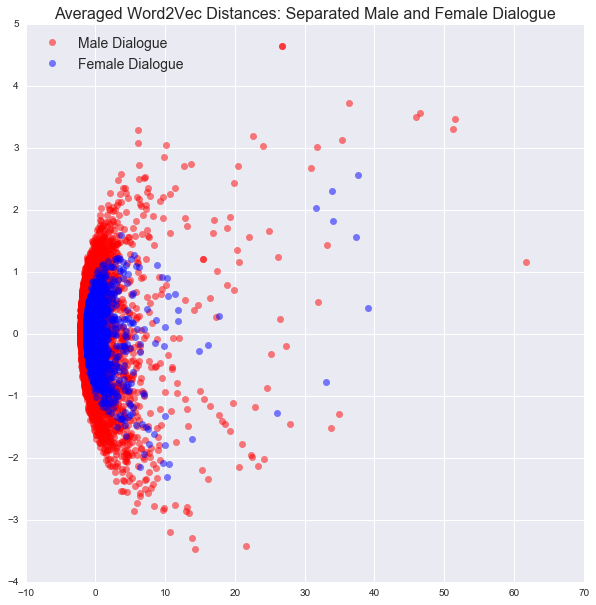

In [142]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

MaleX = [i[0] for i in male_embeddings]
MaleY = [i[1] for i in male_embeddings]
FemaleX = [i[0] for i in female_embeddings]
FemaleY = [i[1] for i in female_embeddings]

plt.plot(MaleX, MaleY, "ro", alpha = .5, label="Male Dialogue")
plt.plot(FemaleX, FemaleY, "bo", alpha = .5, label="Female Dialogue")

plt.legend(loc='upper left', numpoints=1, prop={'size':14}).get_frame().set_edgecolor('black')
plt.title('Averaged Word2Vec Distances: Separated Male and Female Dialogue', fontsize = 16)

plt.show()

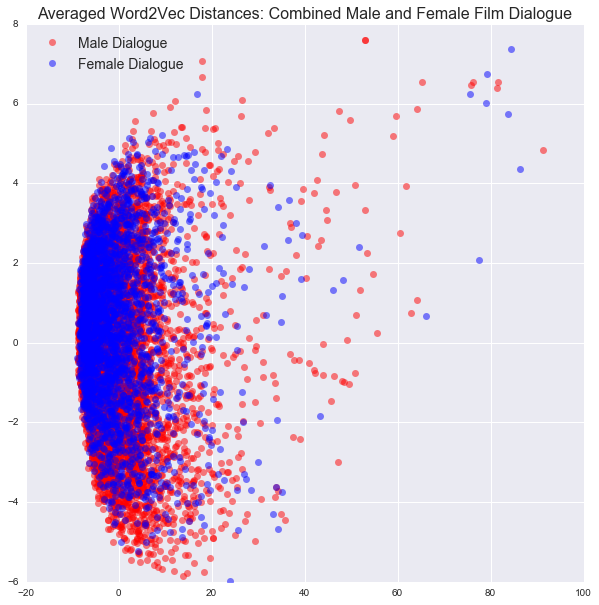

In [141]:
rcParams['figure.figsize'] = 10, 10

m_embeddings = combined_embeddings[:len(average_vectors_male)]
f_embeddings = combined_embeddings[len(average_vectors_male):]

MaleX = [i[0] for i in m_embeddings]
MaleY = [i[1] for i in m_embeddings]
FemaleX = [i[0] for i in f_embeddings]
FemaleY = [i[1] for i in f_embeddings]

plt.plot(MaleX, MaleY, "ro", alpha = .5, label="Male Dialogue")
plt.plot(FemaleX, FemaleY, "bo", alpha = .5, label="Female Dialogue")

plt.legend(loc='upper left', numpoints=1, prop={'size':14}).get_frame().set_edgecolor('black')
plt.title('Averaged Word2Vec Distances: Combined Male and Female Film Dialogue', fontsize = 16)

plt.show()

<a id='modeling'></a>

### ML Classification Model

How well does a logistic regression model perform when classifying male vs. female dialogue?

In [52]:
#  creat labels: 0 for male, 1 for female
labels = np.concatenate((np.zeros(len(clean_male_dialogue)),np.ones(len(clean_female_dialogue))))
all_dialogue = []
all_dialogue.extend(clean_male_dialogue)
all_dialogue.extend(clean_female_dialogue)
labeled_dialogue = [i for i in zip(all_dialogue,labels)]

In [53]:
len(labeled_dialogue)

8284

In [54]:
print(len(clean_male_dialogue))
print(len(clean_female_dialogue))

5617
2667


In [55]:
#remove any dialogue less than 15 words 
for index,dialogue in enumerate(labeled_dialogue):
    if dialogue[0].count(" ") < 15:
        del labeled_dialogue[index]
len(labeled_dialogue)

8204

In [56]:
#shuffle
shuffle(labeled_dialogue)

# separate data and labels into separate lists
x = [i[0] for i in labeled_dialogue]
y = [i[1] for i in labeled_dialogue]

# apply tfidf to data
tfidf = TfidfVectorizer(analyzer="word", sublinear_tf=True)
X = tfidf.fit_transform(x)

# separate into train and test (80/20)
(X_train, X_test, y_train, y_test) = train_test_split(X, y,test_size=.2)

In [57]:
grid_lr = GridSearchCV(LogisticRegression(), param_grid={'C': range(1,9,2)}, cv=5)
grid_lr.fit(X_train, y_train)
grid_lr.score(X_test, y_test)

0.77391834247410118

In [58]:
grid_lr.best_params_

{'C': 7}

In [59]:
lr = LogisticRegression(C=5)
lr.fit(X_train, y_train)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [63]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t{}\t{}\t\t{}\t{}".format(coef_1, fn_1, coef_2, fn_2))

In [64]:
show_most_informative_features(tfidf, lr)

	-6.72884630759	hey		7.95882010462	oh
	-5.47631000301	man		7.22420410825	husband
	-5.22329194852	wife		5.85738513754	god
	-4.98559351788	hell		5.22579328424	hi
	-4.51816465784	kid		5.13775207028	he
	-3.80920135719	son		4.83028730258	cute
	-3.79668249539	eh		4.68617591394	so
	-3.75684741573	whoa		4.55201911332	love
	-3.6765329407	the		4.38186047472	please
	-3.55572569306	problem		3.99940016785	baby
	-3.33373307312	got		3.93450040678	honey
	-3.31816688763	gotta		3.85543248739	coffee
	-3.24699229606	excellent		3.71919767654	hurry
	-3.2179721173	uh		3.545792871	are
	-3.16298098266	friend		3.46759177047	darling
	-3.14429390426	am		3.46009411114	him
	-3.12791377644	ain		3.3905623444	you
	-3.09591163586	guy		3.32658341993	poor
	-3.00954852955	easy		3.31633452169	stop
	-2.97044377523	babe		3.27155338988	isn


In [25]:
y_pred = grid_lr.predict(X_test)

In [27]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[987 102]
 [265 287]]


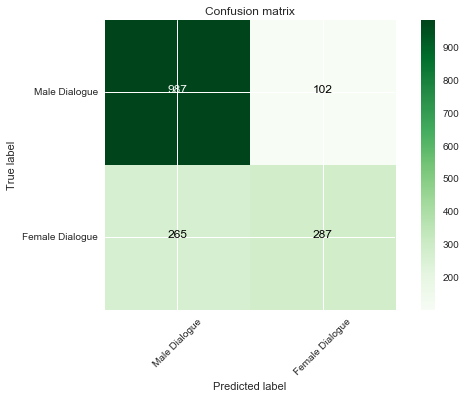

In [28]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Male Dialogue", "Female Dialogue"],
                      title='Confusion matrix')

plt.show()

<a id='modeling2'></a>

### Deep Learning Models

First, going to try a character LSTM network

In [29]:
all_dialogue = x
char_list = list(set(''.join(all_dialogue)))

In [30]:
char_indices = dict((c, i) for i, c in enumerate(char_list))
indices_char = dict((i, c) for i, c in enumerate(char_list))

In [31]:
label_indices = {'male':0,'female':1}
indices_label = {0:'male',1:'female'}

In [14]:
longest_dialogue = 0
i = 0
longest_index = 0

for i,n in enumerate(all_dialogue):
    if len(n) > longest_dialogue:
        longest_dialogue = len(n)
        longest_index = i
        
print("Longest Dialogue: " + str(longest_dialogue))
print(all_dialogue[longest_index][:250])

Longest Dialogue: 53515
what s wrong lou oh no how bad come on napoleon s has a tv set there s still a chance dammit come on jack pull through i didn t always agree with him too liberal for my tastes but i respected him he had style god i m ashamed to be an american today l


In [37]:
MAX_LENGTH = 1000

In [26]:
def dialogue_to_char_seq(dialogue):
    dialogue_chars = list(dialogue)
    dialogue_chars_indices = list(map(lambda char: char_indices[char], dialogue_chars))
    return sequence.pad_sequences([dialogue_chars_indices], maxlen=MAX_LENGTH)[0]

In [27]:
labels = y
X = []
y = []

for n, l in zip(all_dialogue, labels):
    X.append(dialogue_to_char_seq(n))
    y.append(l)
    
X = np.array(X).astype(np.uint8)
y = np.array(y)

print(X.shape, y.shape)

(8204, 1000) (8204,)


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [29]:
model = Sequential()
model.add(Embedding(len(char_list), 32, input_length=MAX_LENGTH, mask_zero=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [30]:
model.compile(loss='binary_crossentropy',optimizer='adagrad', metrics=["accuracy"])

In [31]:
model.fit(X_train,y_train,
          batch_size=32,nb_epoch=2,
          validation_split=0.1,
          verbose=1)

Train on 5906 samples, validate on 657 samples
Epoch 1/2
5906/5906 [==============================] - 521s - loss: 0.6320 - acc: 0.6749 - val_loss: 0.6360 - val_acc: 0.6667
Epoch 2/2
5906/5906 [==============================] - 520s - loss: 0.6295 - acc: 0.6763 - val_loss: 0.6358 - val_acc: 0.6667


In [32]:
model.evaluate(X_test,y_test,batch_size=32)

1641/1641 [==============================] - 42s    


[0.62380968881481524, 0.68494820242462762]

In [33]:
predicted_output = model.predict(X_test,batch_size=32)
predicted_classes = model.predict_classes(X_test, batch_size=32)

1641/1641 [==============================] - 41s    


In [39]:
predictions = predicted_classes.flatten()

In [67]:
#print(classification_report(y_test,predictions))

That didn't turn out very well. How about a word-based RNN model?

In [40]:
def count_words(text):
    return Counter(text.split())

In [43]:
all_dialogue_joined = " ".join(all_dialogue)
count_dict = count_words(all_dialogue_joined)

In [46]:
def remove_from_dict(the_dict,remove_keys):
    for key in remove_keys:
        if key in the_dict:
            del the_dict[key]

In [47]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

remove_from_dict(count_dict,stop_words)

In [48]:
def get_top_words(text_list, top_words):
    new_list = []
    for text in text_list:
        new_list.append([word for word in text.split() if word in top_words])
    return new_list

In [50]:
top_5000 = dict(sorted(count_dict.iteritems(), key=operator.itemgetter(1), reverse=True)[:5000])
new_all_dialogue = get_top_words(all_dialogue,top_5000)

In [51]:
labeled_dialogue = [i for i in zip(new_all_dialogue,labels)]

#remove any dialogue less than 10 words 
for index,dialogue in enumerate(labeled_dialogue):
    if len(dialogue[0]) < 10:
        del labeled_dialogue[index]
len(labeled_dialogue)

8143

In [52]:
#shuffle
shuffle(labeled_dialogue)

# separate data and labels into separate lists
X = [i[0] for i in labeled_dialogue]
y = [i[1] for i in labeled_dialogue]

# separate into train and test (80/20)
(X_train, X_test, y_train, y_test) = train_test_split(X, y,test_size=.2)

In [55]:
max_dialogue_length = 5000

In [56]:
tokenizer = Tokenizer(num_words=max_dialogue_length)

In [54]:
X_train = tokenizer.sequences_to_matrix(X_train, mode='binary')
X_test = tokenizer.sequences_to_matrix(X_test, mode='binary')
y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)

In [62]:
# truncate and pad input sequences
X_train = sequence.pad_sequences(X_train, maxlen=max_dialogue_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_dialogue_length)

# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(5000, embedding_vecor_length, input_length=max_dialogue_length))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [63]:
model.fit(X_train, y_train, epochs=3, batch_size=64)

Epoch 1/3
6514/6514 [==============================] - 2216s - loss: 0.6371 - acc: 0.6749   
Epoch 2/3
6514/6514 [==============================] - 2193s - loss: 0.6250 - acc: 0.6851   
Epoch 3/3
6514/6514 [==============================] - 2219s - loss: 0.6245 - acc: 0.6851   


In [64]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 68.45%


In [68]:
predicted_classes = model.predict_classes(X_test)

1629/1629 [==============================] - 202s   


In [79]:
1 in predicted_classes

False